**Элементарные алгоритмы обработки временных рядов**

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
def test_stationarity(timeseries): # тест на стационарность
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'): # вывод трёх графиков: исходный, ACF и PACF.
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [3]:
dowjones = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
dowjones = dowjones.iloc[:,1]

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


C:\Users\Aleksandr\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


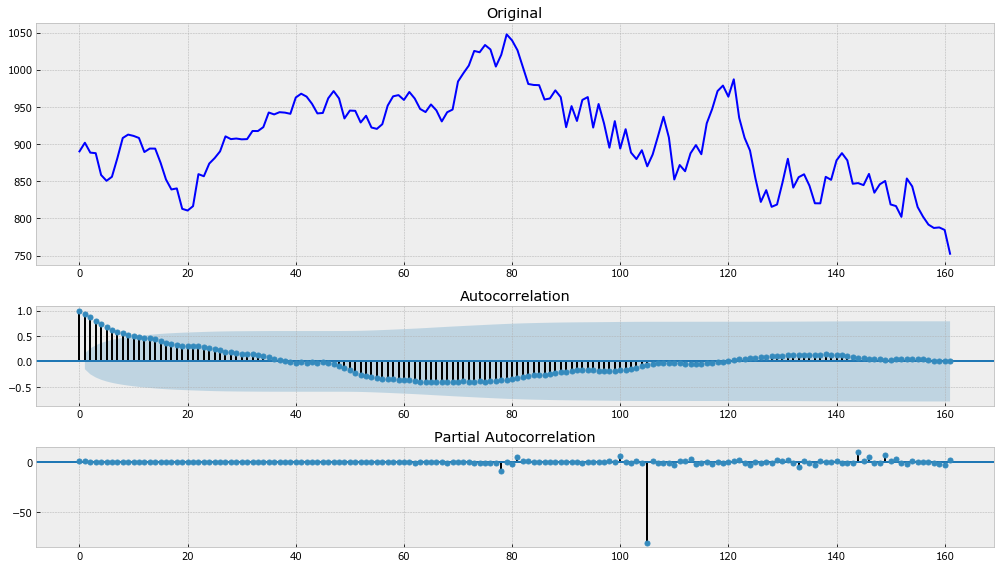

In [4]:
tsplot(dowjones)

**Построим модель из класса MA для данного нестационарного ряда**

In [5]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [6]:
len(dowjones)

162

In [7]:
train, test, val = dowjones[:110], dowjones[110:130], dowjones[130:]

In [8]:
def mse(X):
    alpha, beta = X
    result = double_ema(train, alpha, beta)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [9]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

def plot_dema(alpha, beta):
    dema = double_ema(dowjones, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(dowjones, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [10]:
opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [11]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 694.4491334296088
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.46833689e-03, -1.21737171e+03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 90
      nit: 18
   status: 0
  success: True
        x: array([0.09768591, 1.        ])


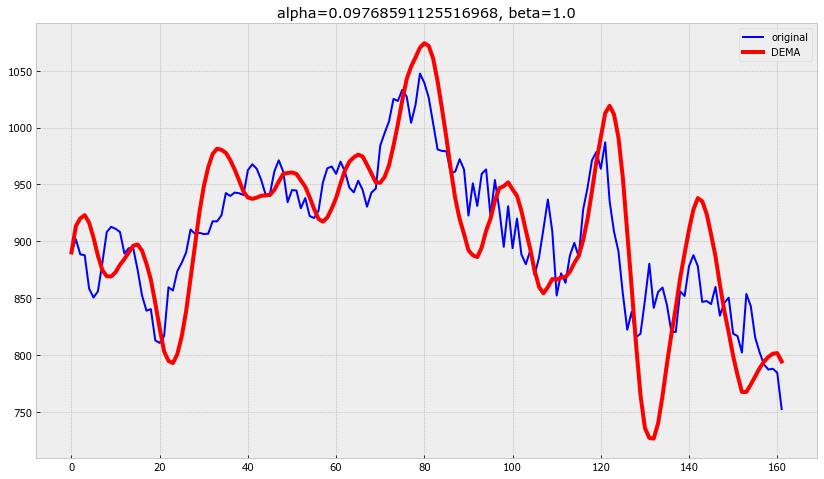

In [12]:
plot_dema(alpha_opt, beta_opt)

***Теперь найдём лучшие параметры DEMA при помощи кросс-валидации*** 

In [13]:
train, val = dowjones[:130], dowjones[130:]

In [14]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3)
    errors = []
    
    for train_split, test_split in split.split(train):
        result = double_ema(train, alpha, beta)
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [15]:
opt = minimize(mse_cross_val, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [16]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 663114.3492293908
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1015.51413536, -3535.42855009])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 102
      nit: 19
   status: 0
  success: True
        x: array([0.31596908, 0.90883326])


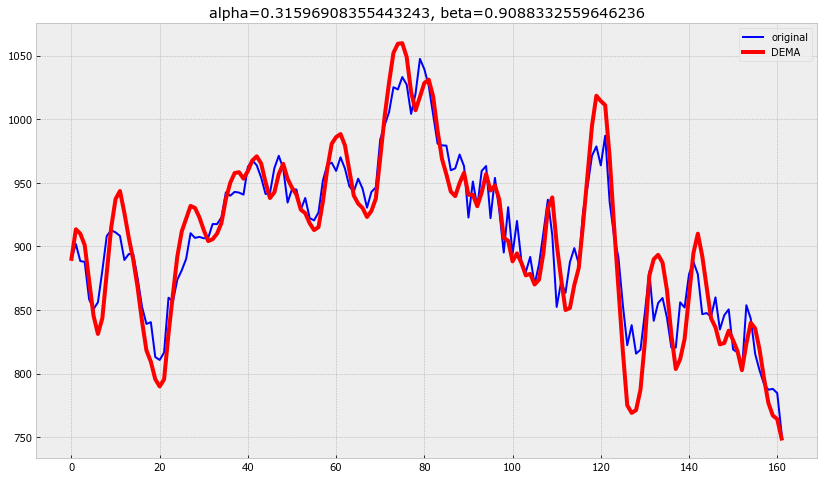

In [17]:
plot_dema(alpha_opt, beta_opt)

**Теперь найдём DEMA для стационарного ряда. Как мы помним, в решении первого домашнего задания мы два раза дифференцировали исходный ряд, чтобы получить стационарный ряд.**

In [18]:
dowjones = boxcox(dowjones, 0)
dowjones = np.diff(dowjones, 2)

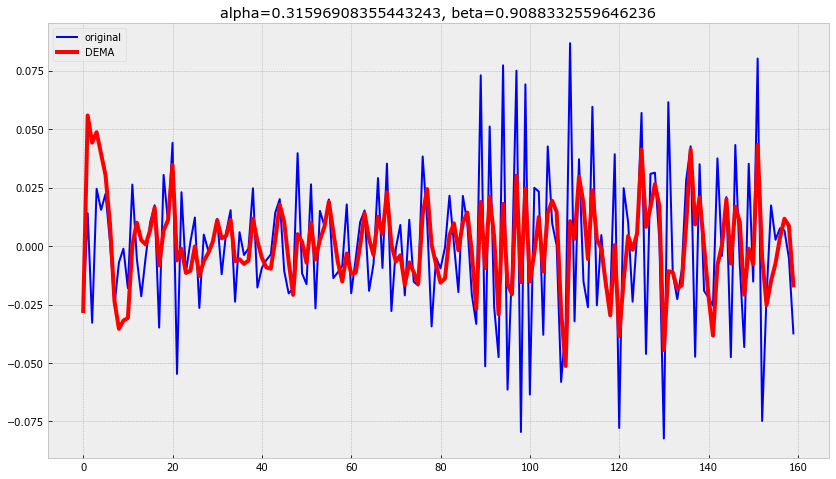

In [19]:
def mse_cross_val_diff(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    for train_split, test_split in split.split(train):
        result = double_ema(train, alpha, beta)
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)
    return np.mean(np.array(errors))

opt = minimize(mse_cross_val_diff, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha_opt, beta_opt = opt.x
plot_dema(alpha_opt, beta_opt)

In [20]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 663114.3492293908
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1015.51413536, -3535.42855009])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 102
      nit: 19
   status: 0
  success: True
        x: array([0.31596908, 0.90883326])


**В итоге для данных рядов мы подобрали оптимальные модели DEMA (двойных экспоненциальных скользящих средних). Альфа и бета были подобраны так, чтобы среднеквадратичная ошибка на кроссвалидации была наименьшей.**